In [8]:
import numpy as np 
import pandas as pd
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
import time 
from tqdm.notebook import tqdm 

In [ ]:
# get target data (Lilac 114, Neuron 1, epoch_1.txt)
# Column1: Current, Column2: Voltage
lilac_114_1_1 = pd.read_csv('./Data2022-50KhZ/7-7-2022/Lilac 114/Neuron 1/epoch_1.txt', delimiter='\t', header=None)
lilac_114_1_1.reset_index(inplace=True)
lilac_114_1_1.columns = ['Time', 'Current', 'Voltage']
lilac_114_1_1.head()

,Time,Current,Voltage
0,0,-4.179686,-64.490236
1,1,0.092775,-64.337648
2,2,-7.841795,-64.581788
3,3,0.092775,-64.307130
4,4,-2.958983,-64.429200


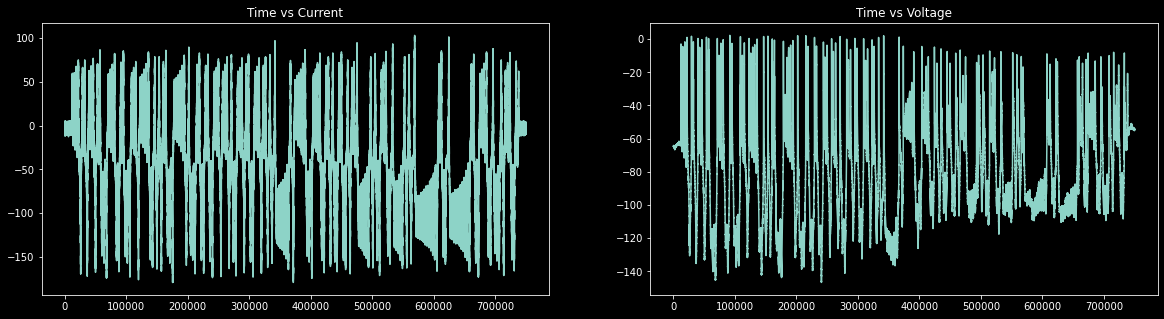

In [3]:
# plot to visualize 
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.set_title("Time vs Current")
ax1.plot(lilac_114_1_1.Time, lilac_114_1_1.Current)
ax2.set_title("Time vs Voltage")
ax2.plot(lilac_114_1_1.Time, lilac_114_1_1.Voltage)
plt.show()

#### False Nearest Neighbor Algorithm to Determine Time Delay Vector Dimensionality 

##### Procedure
1. Define the target time delay vector (regressor) to run FNN on, and then generate time delay vectors for each time step of the voltage data: $\psi_{l}(t) = [y(k-\tau), ..., y(k-l \tau)] \text{ where } l\in[0, D]$.
2. For each points, identify the closest point in time delay space (we can search within a window, or through out all points), i.e. minimize this distance: $d = ||\psi_{l}(t_1) - \psi_{l}(t_2)||$.
3. The inequality below determines if two closest points are "true neighbors" or "false neighbors": $$\frac{|y(t)-y(j)|}{||\psi_l(t) - \psi_l (j)||_2} \leq R$$
    - If inequality is true, then the two points are true neighbors. 
    - If inequality is false, then the two points are false neighbors. 
4. Repeat step 3 for all points in the dataset, and then record the percentage of points in datasets with false nearest neighbors, giving the current time delay vector dimension. 
5. Increase the value of D until the percentage of false nearest neighbors is minimized. 

##### 1. Create time delay vectors

In [4]:
# define tau (user provided), distance ratio threshold R (user defined hyperparameter), and range of D to search over (trainable parameter)
tau = 10
R_ratio = 10 # TODO: Investigate optimal value of R; 10 is suggested by the original paper 
D_arr = np.array([2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100])

In [5]:
# create the time delay vectors for each data points with each of the D values
original_data = lilac_114_1_1.to_numpy()
T = original_data[:, 0]
I = original_data[:, 1]
V_0 = original_data[:, 2] # voltage at 0*tau

# time the operation 
start = time.time()

# store all the array in a list
time_delay_datasets = [V_0[:-D*tau][:, np.newaxis] for D in D_arr] # shape = (12, 750000, 1)

for D_index in range(len(D_arr)): 
    # for each D we want to append to the array of data, a new dimension of voltage 
    time_delay_datasets[D_index] = np.concatenate(
                                            [time_delay_datasets[D_index], 
                                                np.array([V_0[d*tau:-(D_arr[D_index]-d)*tau] 
                                                if -(D_arr[D_index]-d)*tau != 0 else V_0[d*tau:]
                                                for d in range(1, 1+D_arr[D_index])]).T], 
                                            axis=1)
    
end = time.time()

print(f"This took {end-start}.")        

This took 1.3379969596862793.


In [6]:
# check the datasets shapes
for D_index in range(len(D_arr)): 
    print(f"For D={D_arr[D_index]}, the shape of the dataset is {time_delay_datasets[D_index].shape}")

For D=2, the shape of the dataset is (749980, 3)
For D=5, the shape of the dataset is (749950, 6)
For D=10, the shape of the dataset is (749900, 11)
For D=15, the shape of the dataset is (749850, 16)
For D=20, the shape of the dataset is (749800, 21)
For D=25, the shape of the dataset is (749750, 26)
For D=30, the shape of the dataset is (749700, 31)
For D=40, the shape of the dataset is (749600, 41)
For D=50, the shape of the dataset is (749500, 51)
For D=60, the shape of the dataset is (749400, 61)
For D=80, the shape of the dataset is (749200, 81)
For D=100, the shape of the dataset is (749000, 101)


In [7]:
# check the data 
"""
Every second element should match up with the first element of the Dth row down the line, i.e. array[0, 1] == array[D, 1] 
"""
time_delay_datasets[0][:10] 


array([[-64.49023555, -64.30713008, -64.45971797],
       [-64.33764765, -64.2766125 , -64.58178828],
       [-64.58178828, -64.58178828, -64.33764765],
       [-64.30713008, -64.30713008, -64.58178828],
       [-64.42920039, -64.55127071, -64.55127071],
       [-64.52075313, -64.33764765, -64.2766125 ],
       [-64.2766125 , -64.67334102, -64.67334102],
       [-64.36816523, -64.52075313, -64.52075313],
       [-64.24609492, -64.24609492, -64.64282344],
       [-64.64282344, -64.58178828, -64.42920039]])

##### 2. Calculate distance between points, and for each point, find its closest point

In [9]:
def calc_min_distance(data_point, array_points): 
    """Given a data point and its corresponding dataset, return the distance between that point to all other points in the array points"""
    distance = np.linalg.norm(array_points - data_point, axis=1)
    result = np.array([data_point, array_points[np.argmin(distance)]])
    return result

The process of find the nearest point for all available points in the dataset takes 2 hours (projected) for each dataset, lets try this with a smaller window=200

In [16]:
# calculate the min distance result (test) - window=200 will run for 20 mins
test_data = time_delay_datasets[0]
def generate_min_dist_datapoints(data, window=100): 
    result = np.array([])
    for i in tqdm(range(len(test_data))): 
        result = np.append(result, calc_min_distance(test_data[i], test_data[max(i-100, 0):min(len(test_data), i+100)]))
    
    print("Saving results...")
    np.save(f'min_datapairs_D={test_data.shape[1]}_window={window}', result)
    print("Results saved.")
    return result

test_result = generate_min_dist_datapoints(test_data)

  0%|          | 0/749980 [00:00<?, ?it/s]

In [ ]:
# check the result


##### 3. Count the number of False Nearest Neighbors and True Nearest Neighbors in the current setup 

In [ ]:
def count_fnn(dataset, threshold_R=R):
    """
    Parameters: 
    dataset: A dataset should contain all the points and their closest point in pairs; example [(point_vec1, point_vec2)_1, (point_vec1, point_vec2)_2, ...]
    threshold_R: This threshold determines ratio needed between the actual distance and the time delay distance to be recognized as a true nearest neighbor

    Return: 
    A floating point number indicating the number of false nearest neighbors in the dataset. 
    """
    tnn, fnn = 0, 0
    for vec1, vec2 in dataset: 
        true1, true2 = vec1[0], vec2[0]# the first value of each array are the true voltage value 
        time_dist = np.linalg.norm(vec1 - vec2, ord=2) # time delay distance between the two points 
        actual_dist = np.abs(true1 - true2) # actual distance 
        dist_ratio = actual_dist / time_dist 

        if dist_ratio <= threshold_R: # determine falsehood 
            fnn += 1
        else: 
            tnn += 1
    return fnn / (fnn+tnn)
    

In [ ]:
# test the function on the first dataset
fnn_ratio = count_fnn(test_result)

##### 4. Repeat the search for all D values

In [ ]:
# iterate through the D array and run the ratio calculation algorithm 
from collections import defaultdict
result = defaultdict(float)
for d_index in range(len(D_arr)): 
    dataset = time_delay_datasets[d_index] # get the time delay vectors 
    min_dist_vector_pairs = generate_min_dist_datapoints(dataset) # generate data pairs 
    result[D_arr[d_index]] = count_fnn(min_dist_vector_pairs)
    

In [ ]:
# visualize the result 
fig = plt.figure(figsize=(10,10))
plt.scatter(list(result.keys()), list(result.values()), c='green')
plt.show()